In [1]:
import numpy
import torch
import torch.nn.functional as F
import logging
logging.basicConfig(level=logging.INFO)

from myTorch.task.copying_memory import CopyingMemoryData
from myTorch.memnets.load import load_experiment
import matplotlib.pyplot as plt


/home/sarath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
models = list()
model_names = list()
model_colors = list()
models.append("/mnt/data/sarath/nips/backup/v1/instance4/output/denoising_copy_task_t100/lstm_chrono")
model_names.append("chrono")
model_colors.append("r")
#models.append("/mnt/data/chinna/output/copying_memory_task/mask_1/current")
#model_names.append("LSTM")
#model_colors.append("b")
#models.append("/mnt/data/chinna/output/copying_memory_task/flatmemory_m64_k4_h80_linear/current")
#model_names.append("FlatMemory")
#model_colors.append("g")


In [7]:
def get_stats(save_dir):
    experiment, model, data_iterator, device, config = load_experiment(save_dir)
    config.time_lag = 100
    config.batch_size = 1
    config.seed = 1000
    new_data_iterator = CopyingMemoryData(seq_len=config.seq_len, time_lag_min=config.time_lag_min,
                                          time_lag_max=config.time_lag_max, num_noise_digits=config.num_noise_digits,
                                          num_digits=config.num_digits,
                                          batch_size=config.batch_size, seed=config.seed)
    data_iterator = new_data_iterator
    
    data = data_iterator.next()
    seqloss = 0

    model.reset_hidden(batch_size=1)

    hiddens = []

    for i in range(0, data["datalen"]):

        x = torch.from_numpy(numpy.asarray(data['x'][i])).to(device)
        y = torch.from_numpy(numpy.asarray(data['y'][i])).to(device)
        mask = float(data["mask"][i])

        model.optimizer.zero_grad()

        output = model(x)
        hiddens.append(model._h_prev[0]["h"])
        hiddens[-1].requires_grad_()
        print(output)
        print(y.squeeze(1))
        if config.task == "copying_memory":
            loss = F.torch.nn.functional.cross_entropy(output, y.squeeze(1))
        else:
            #loss = F.binary_cross_entropy_with_logits(output, y)
            loss = F.torch.nn.functional.cross_entropy(output, y.squeeze(1))

        seqloss += (loss * mask)

    seqloss /= sum(data["mask"])

    hidden_norms = list()
    hidden_diff = list()
    hidden_grads = list()
    for i in range(0, len(hiddens)):
        hidden_diff.append((hiddens[i]-hiddens[-1]).norm().item())
        hidden_norms.append(hiddens[i].norm().item())
    for i in range(0, len(hiddens)):
        model.optimizer.zero_grad()
        grad = torch.autograd.grad(loss, hiddens[i], retain_graph=True)
        hidden_grads.append(grad[0].norm().item())
    return hidden_norms, hidden_diff, hidden_grads
    

In [8]:
hidden_norm_list = list()
hidden_diff_list = list()
hidden_grad_list = list()

for i in range(0, len(models)):
    hidden_norm, hidden_diff, hidden_grad = get_stats(models[i])
    hidden_norm_list.append(hidden_norm)
    hidden_diff_list.append(hidden_diff)
    hidden_grad_list.append(hidden_grad)

INFO:root:using cpu
/mnt/data/sarath/code/myTorch/myTorch/memnets/recurrent_net.py:93: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self._W_h2o, gain=nn.init.calculate_gain(self._output_activation))
/mnt/data/sarath/code/myTorch/myTorch/memnets/recurrent_net.py:94: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self._b_o, 0)
INFO:root:Loading the experiment from /mnt/data/sarath/nips/backup/v1/instance4/output/denoising_copy_task_t100/lstm_chrono


111
Num_params : 23529 
/mnt/data/sarath/nips/backup/v1/instance4/output/denoising_copy_task_t100/lstm_chrono/current/flag.p
tensor([[-0.7062,  0.0287, -0.3662, -2.2474, -2.0918, -2.1939,  6.1414,
          0.1177, -1.0578]])
tensor([ 0])
tensor([[-0.6884,  0.6324, -1.4451, -4.3523, -1.1286, -3.7643,  6.3060,
          0.7849,  0.6083]])
tensor([ 0])
tensor([[-0.6654,  0.7097, -1.9217, -7.6005,  0.1801, -4.8431,  7.7209,
          1.3876,  1.7594]])
tensor([ 0])
tensor([[-0.5340, -0.5892, -2.5817, -7.2776,  1.8683, -6.2619,  5.7759,
          0.6364,  4.7682]])
tensor([ 0])
tensor([[-0.9550, -0.6209, -5.0388, -9.4577,  7.7712, -8.9651,  5.6466,
         -2.2411,  7.7862]])
tensor([ 0])
tensor([[ -0.5612,   1.8832,  -3.7129,  -9.2738,   8.3120,  -9.8215,
           2.0929,  -8.3066,  12.3323]])
tensor([ 0])
tensor([[ -0.8497,   3.5672,  -5.4461, -11.4793,   5.5904,  -7.7825,
           3.5524,  -3.6147,  10.4717]])
tensor([ 0])
tensor([[ -1.1820,   0.3808,  -4.9376, -11.6476,   0.2646, 

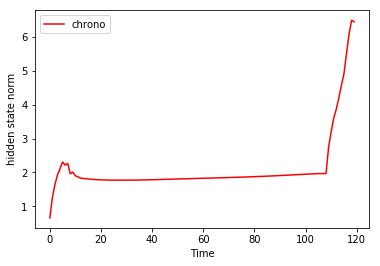

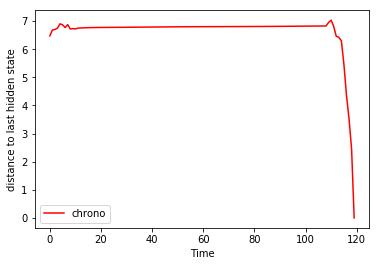

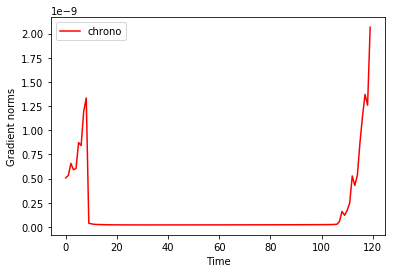

In [9]:
for i in range(0, len(models)):
    plt.plot(hidden_norm_list[i], color=model_colors[i], label=model_names[i])

plt.ylabel('hidden state norm')
plt.xlabel('Time')
plt.legend()
plt.show()


for i in range(0, len(models)):
    plt.plot(hidden_diff_list[i], color=model_colors[i], label=model_names[i])

plt.ylabel('distance to last hidden state')
plt.xlabel('Time')
plt.legend()
plt.show()

for i in range(0, len(models)):
    plt.plot(hidden_grad_list[i], color=model_colors[i], label=model_names[i])

plt.ylabel('Gradient norms')
plt.xlabel('Time')
plt.legend()
plt.show()